In [1]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
%matplotlib inline
import random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from IPython.display import HTML


# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template# The data to load

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
train = pd.read_csv("Data/MergedTrainData.csv")


C:\Users\d56444\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
transactions = pd.read_csv("Data/transactions.csv")
oil = pd.read_csv("Data/oil.csv")

# Story Telling

## Problem Statement
Corporacion Favorita, a grocery store chain in Ecuador, has asked us to provide a better sales forecast for the more than 4,000 items they stock on the shelves of their 50 locations. An accurate forecast will help them better satisfy customer demand. If they stock too much inventory, they run the risk of having to scrap a lot of perishable goods. On the other hand, if they don’t carry enough inventory, customers may turn to other grocery stores for future needs. By preventing either of these occurrences, Corporacion Favorita can cut costs while strengthening customer loyalty and securing future business. 

## Introduction
In the problem statement on Kaggle, there are a few factors discussed that could potentially sway sales. One of these is the price of oil. According to the dataset: 
>Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In this report, we will discuss the influence of oil prices on sales. As the statement above is phrased, the implication seems to be that high oil prices suggest good times in the Ecuadorian economy, and good times equate to higher sales. Therefore, we will explore the relationship between oil prices and unit sales and evaluate this assumption.

## Oil Prices vs Unit Sales
The most basic method of evaluating the relationship between oil prices and unit sales is to check for correlation. In the scatterplot below, we see the sum total of unit sales across the entire chain on each day compared to the price of oil on that day. 


In [5]:
# Sum up unit_sales by date
unit_sales_vs_oil_df = pd.pivot_table(data=train, index='date', values='unit_sales', aggfunc='sum', dropna=False)
# Join the unit sales with the oil price on that day
unit_sales_vs_oil_df = pd.merge(unit_sales_vs_oil_df, oil, on='date', how='left')
# Replace NaN values using backward fill to cover first date 
unit_sales_vs_oil_df['dcoilwtico'].fillna(method='bfill', inplace=True)
# Convert date column to datetime
unit_sales_vs_oil_df['date'] =  pd.to_datetime(unit_sales_vs_oil_df['date'], format='%Y-%m-%d')

#Extract the unit sales and oil prices
unit_sales = unit_sales_vs_oil_df['unit_sales'].values
oil_prices = unit_sales_vs_oil_df['dcoilwtico'].values

In [6]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    
    # Set up array of indices to sample from
    inds = np.arange(len(x))
    
    # Initialize replicates
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
        
    return bs_slope_reps, bs_intercept_reps

In [7]:
# Compute the linear regression
slope, intercept = np.polyfit(oil_prices, unit_sales, 1)

# Perform pairs bootstra for the linear regression
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(oil_prices, unit_sales, 1000)

# Compute confidence intervals of slope and intercept
slope_conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])
intercept_conf_int = np.percentile(bs_intercept_reps, [2.5, 97.5])

# Print the results
#print('Slope = ', slope, 'conf int =', slope_conf_int)
#print('Intercept =', intercept, 'conf int =', intercept_conf_int)

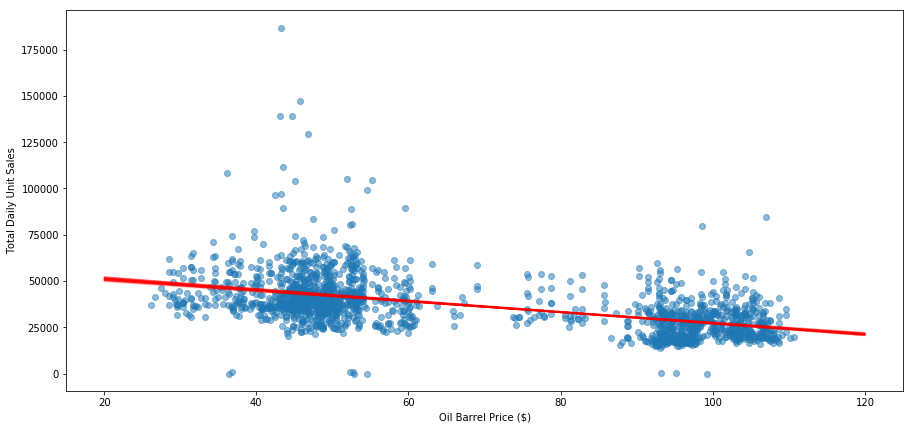

In [8]:
# Make a scatter plot of the data
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('Oil Barrel Price ($)')
ax1.set_ylabel('Total Daily Unit Sales')
ax1.scatter(oil_prices, unit_sales, color=color, alpha=0.5)

# Generate x-values for bootstrap lines
x = np.array([20, 120])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

plt.show()

In [8]:
# Calculate the correlation
pearson_r = np.corrcoef(unit_sales, oil_prices)[0, 1]
print("Pearson correlation coefficient: {:+.3f}".format(pearson_r))

Pearson correlation coefficient: -0.515


At first glance, a clear negative correlation appears. While -.515 is not an extremely strong correlation, it is important to remember the context. In the case of sales at a grocery store chain, there are many factors, macroeconomic and otherwise, that play a role. The fact that a single factor, namely the price of oil, can play such a large role is worth noting. If anything, it seems clear that whatever model we choose to predict future sales should account for oil prices.

However, another feature of the scatterplot should make us suspicious. The inarguably bimodal nature of the scatterplot definitely warrants further investigation. When we introduce the time dimension, we get a much better sense of what is happening.

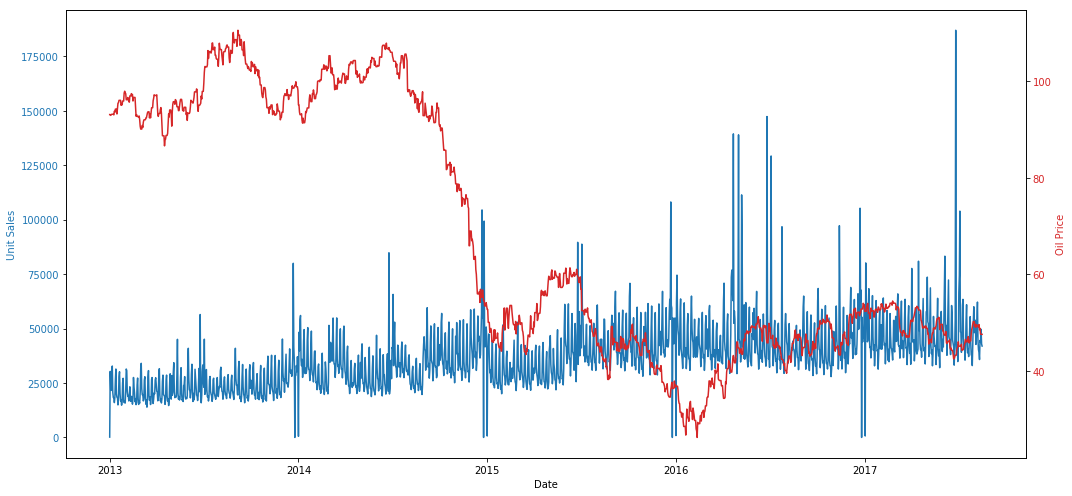

In [9]:
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Unit Sales', color=color)
ax1.plot(unit_sales_vs_oil_df.date, unit_sales_vs_oil_df.unit_sales, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Oil Price', color=color)  # we already handled the x-label with ax1
ax2.plot(unit_sales_vs_oil_df.date, unit_sales_vs_oil_df.dcoilwtico, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

When we plot the unit sales over time, and then overlay the price of oil, we immediately see what lies behind the bimodal nature of our scatter plot. We see that prior to Autumn 2014, the price of oil hovered around \\$100. Then, in Autumn 2014, the price of oil plummetted to the 40-50\\$ range. During this time, sales continued to trend upward as a fairly steady rate. In effect, we get the misleading view that lower oil prices led to higher sales. Because such a shift in the macroeconomic environment is very atypical, we should slice our data into two parts: before the crash and after the crash. That way, we can get a better view of the effects of oil prices in "steady" times.

Below, I have split the sales data to the sales leading up to October 2014, around the time when the price of oil began to plummet, and the sales following January 1, 2015, when the price of oil began to "stabilize." 

### Before Oil Price Crash

In [10]:
data_pre_decline = train[train['date'] < '2014-10-01']
# Sum up unit_sales by date
unit_sales_vs_oil_pre_df = pd.pivot_table(data=data_pre_decline, index='date', values='unit_sales', aggfunc='sum', dropna=False)
unit_sales_vs_oil_pre_df = pd.merge(unit_sales_vs_oil_pre_df, oil, on='date', how='left')
# Replace NaN values using backward fill to cover first date 
unit_sales_vs_oil_pre_df['dcoilwtico'].fillna(method='bfill', inplace=True)
unit_sales_vs_oil_pre_df['date'] = pd.to_datetime(unit_sales_vs_oil_pre_df['date'], format='%Y-%m-%d')
unit_sales_pre = unit_sales_vs_oil_pre_df['unit_sales'].values
oil_prices_pre = unit_sales_vs_oil_pre_df['dcoilwtico'].values

In [11]:
# Compute the linear regression
slope, intercept = np.polyfit(oil_prices_pre, unit_sales_pre, 1)

# Perform pairs bootstra for the linear regression
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(oil_prices_pre, unit_sales_pre, 1000)

# Compute confidence intervals of slope and intercept
slope_conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])
intercept_conf_int = np.percentile(bs_intercept_reps, [2.5, 97.5])

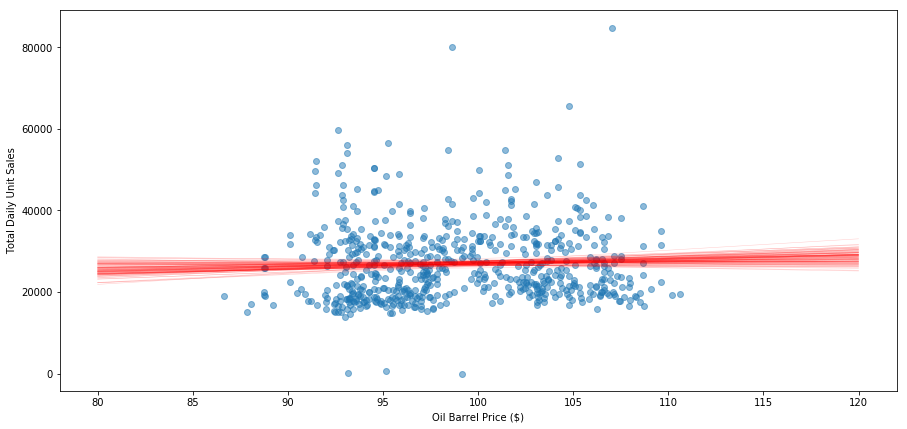

In [12]:
# Make a scatter plot of the data
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('Oil Barrel Price ($)')
ax1.set_ylabel('Total Daily Unit Sales')
ax1.scatter(oil_prices_pre, unit_sales_pre, color=color, alpha=0.5)

# Generate x-values for bootstrap lines
x = np.array([80, 120])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

plt.show()

In [13]:
# Calculate the correlation
pearson_r = np.corrcoef(unit_sales_pre, oil_prices_pre)[0, 1]
print("Pearson correlation coefficient: {:+.3f}".format(pearson_r))

Pearson correlation coefficient: +0.044


### After Oil Price Crash

In [14]:
data_post_decline = train[train['date'] >= '2015-01-01']
# Sum up unit_sales by date
unit_sales_vs_oil_post_df = pd.pivot_table(data=data_post_decline, index='date', values='unit_sales', aggfunc='sum', dropna=False)
unit_sales_vs_oil_post_df = pd.merge(unit_sales_vs_oil_post_df, oil, on='date', how='left')
# Replace NaN values using backward fill to cover first date 
unit_sales_vs_oil_post_df['dcoilwtico'].fillna(method='bfill', inplace=True)
unit_sales_vs_oil_post_df['date'] = pd.to_datetime(unit_sales_vs_oil_post_df['date'], format='%Y-%m-%d')
unit_sales_post = unit_sales_vs_oil_post_df['unit_sales'].values
oil_prices_post = unit_sales_vs_oil_post_df['dcoilwtico'].values

In [15]:
# Compute the linear regression
slope, intercept = np.polyfit(oil_prices_post, unit_sales_post, 1)

# Perform pairs bootstra for the linear regression
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(oil_prices_post, unit_sales_post, 1000)

# Compute confidence intervals of slope and intercept
slope_conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])
intercept_conf_int = np.percentile(bs_intercept_reps, [2.5, 97.5])

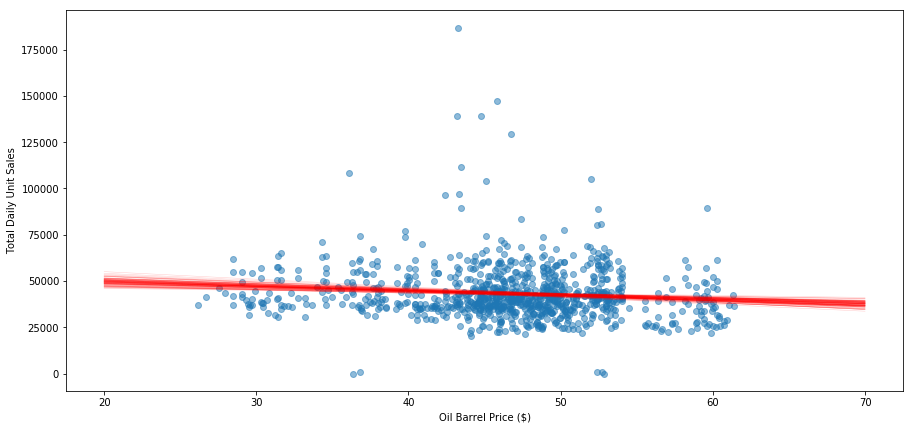

In [16]:
# Make a scatter plot of the data
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('Oil Barrel Price ($)')
ax1.set_ylabel('Total Daily Unit Sales')
ax1.scatter(oil_prices_post, unit_sales_post, color=color, alpha=0.5)

# Generate x-values for bootstrap lines
x = np.array([20, 70])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

plt.show()

In [16]:
# Calculate the correlation
pearson_r = np.corrcoef(unit_sales_post, oil_prices_post)[0, 1]
print("Pearson correlation coefficient: {:+.3f}".format(pearson_r))

Pearson correlation coefficient: -0.108


### Results

When the two time periods are taken separately, the correlation almost completely disappears. There is an important lesson to be learned here and that is that correlations can be misleading. The initial comparison of total unit sales and oil prices demonstrated a significant negative correlation. Upon deeper analysis, it became evident that the macroeconomic environment between the two time periods had completely changed. In such cases, it is useful to separate the data and treat the two macroeconomic environments separately. 

## Store Count vs Unit Sales

Over the time period covered by the training data, Corporacion Favorita went from having 46 locations throughout Ecuador to having 54 locations. It would be useful to know how the opening of new locations impacted sales. Did the new locations "steal" customers from existing locations? Or did they succeed in expanding Corporacion Favorita's customer base and increasing sales? In the plot below, we compare store count to the total unit sales. 

In [45]:
# To start, let's combine all unit sales by location and date
unit_sales_vs_stores_df = pd.pivot_table(data=train, index=('date', 'store_nbr'), values='unit_sales', aggfunc='sum', dropna=False)

# Filter on only those store and date combinations where the unit sales was greater than 0
unit_sales_vs_stores_df = unit_sales_vs_stores_df[unit_sales_vs_stores_df['unit_sales'] > 0]

# Create a table that contains how many stores had sales on a given date
stores_over_time_df = pd.pivot_table(data=unit_sales_vs_stores_df, index='date', values='unit_sales', aggfunc='count', dropna=False)
stores_over_time_df.index = pd.to_datetime(stores_over_time_df.index, format='%Y-%m-%d')
# There are a handful of days where only one or two stores have sales. These appear to be outliers and they throw off the plot.
# Filtering to days with at least 40 stores with sales
stores_vs_unit_sales = pd.merge(stores_over_time_df, unit_sales_vs_oil_df, on='date', how='left')
stores_vs_unit_sales = stores_vs_unit_sales[stores_vs_unit_sales['unit_sales_x'] > 40]

unit_sales = stores_vs_unit_sales['unit_sales_y'].values
store_cnt = stores_vs_unit_sales['unit_sales_x'].values

In [46]:
# Compute the linear regression
slope, intercept = np.polyfit(store_cnt, unit_sales, 1)

# Perform pairs bootstra for the linear regression
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(store_cnt, unit_sales, 1000)

# Compute confidence intervals of slope and intercept
slope_conf_int = np.percentile(bs_slope_reps, [2.5, 97.5])
intercept_conf_int = np.percentile(bs_intercept_reps, [2.5, 97.5])

# Print the results
#print('Slope = ', slope, 'conf int =', slope_conf_int)
#print('Intercept =', intercept, 'conf int =', intercept_conf_int)

# Make a scatter plot of the data
#_ = plt.plot(store_cnt, unit_sales, marker = '.', 
#            linestyle='none', color='blue', alpha=0.5)

# Label axes and make legend
#_ = plt.xlabel('Store Count')
#_ = plt.ylabel('Total Daily Unit Sales')
#_ = plt.legend(('Store Count', 'Total Daily Unit Sales'), loc='upper left')

# Generate x-values for bootstrap lines
#x = np.array([44, 56])

# Plot the bootstrap lines
#for i in range(100):
#    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
#plt.show()

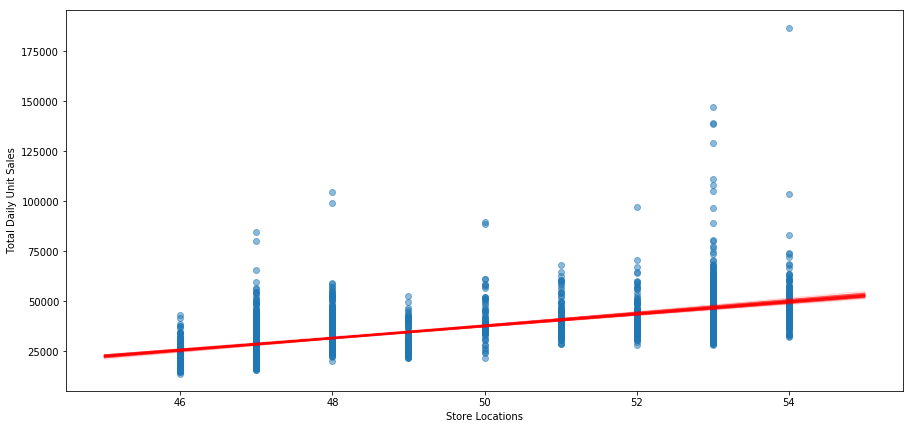

In [48]:
# Make a scatter plot of the data
fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('Store Locations')
ax1.set_ylabel('Total Daily Unit Sales')
ax1.scatter(store_cnt, unit_sales, color=color, alpha=0.5)

# Generate x-values for bootstrap lines
x = np.array([45, 55])

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x, bs_slope_reps[i] * x + bs_intercept_reps[i], linewidth=0.5, alpha=0.2, color='red')

plt.show()

In [49]:
# Calculate the correlation
pearson_r = np.corrcoef(store_cnt, unit_sales)[0, 1]
print("Pearson correlation coefficient: {:+.3f}".format(pearson_r))

Pearson correlation coefficient: +0.590


It is fair to say that each new store is associated with increased total sales in aggregate. Based on the linear regression, each new store translates into about 3000 more units sold each day. This suggests that each new store help to widen Corporacion Favorita's customer base, as opposed to new stores stealing sales from existing locations. 

## Conclusion
At this point in our analysis, I believe it is safe to rule out any strong correlation between the price of oil and the total unit sales. Day to day fluctuations in price do not seem to correlate well with sales. In addition, the steep decline in oil prices around the end of 2014 does not seem to have stopped the upward trend in unit sales. 

Also, we have seen evidence that each new store location has helped Corporacion Favorita increase sales, as opposed to stealing business from existing locations. 